<a href="https://colab.research.google.com/github/PragyaKumari2203/Image-Captioning-Model/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pre-requisites and Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Image-Captioning-Model

/content/drive/MyDrive/Image-Captioning-Model


In [3]:
import os
import string
import nltk
import numpy as np
import torch
from collections import defaultdict, Counter
from torchvision import transforms, models
from PIL import Image, UnidentifiedImageError
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
import random
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import heapq
import requests
from io import BytesIO
import pickle

In [4]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

# **Data Preparation**




In [5]:
PATH_TO_CAPTIONS = "./Flickr8K/Flickr8k_text/Flickr8k.token.txt"
PATH_TO_IMAGES = "./Flickr8K/Flickr8k_Dataset"
PATH_TO_TRAINING_DATA = "./Flickr8K/Flickr8k_text/Flickr_8k.trainImages.txt"
PATH_TO_VALID_DATA = "./Flickr8K/Flickr8k_text/Flickr_8k.devImages.txt"
PATH_TO_TEST_DATA = "./Flickr8K/Flickr8k_text/Flickr_8k.testImages.txt"
PATH_TO_GLOVE = "./glove.6B/glove.6B.300d.txt"

## Utility functions



In [6]:
def load_captions(filepath):
  with open(filepath,'r') as f:
    lines = f.readlines()
  captions = defaultdict(list)
  for line in lines:
    img_id, caption = line.strip().split('\t')
    img_id = img_id[:-2]
    tokens = nltk.word_tokenize(caption.lower())
    tokens = [word for word in tokens if word not in string.punctuation]
    cleaned_caption = ' '.join(tokens)
    captions[img_id].append(cleaned_caption)
  return captions


def image_transforms():
  return transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
  ])


def load_image_list(filepath):
  with open(filepath,'r') as f:
    return [line.strip() for line in f.readlines()]


def collate_fn(batch):
  images, captions = zip(*batch)
  images = torch.stack(images, dim=0)
  padded_captions = pad_sequence(captions, batch_first=True, padding_value=0)
  lengths = [len(caps) for caps in captions]
  return images, padded_captions, lengths

## Vocabulary Creation

In [7]:
class Vocabulary:
  def __init__(self,freq_threshold):
    self.freq_threshold = freq_threshold
    self.idx2word = {0: '<pad>', 1: '<sos>', 2: '<eos>', 3: '<unk>'}
    self.word2idx = {v:k for k, v in self.idx2word.items()}
    self.embeddings = None
    self.word_freq = Counter()
    self.idx = 4


  def __len__(self):
    return len(self.word2idx)


  def build_vocab(self,captions_dict):
    for _, captions in captions_dict.items():
      for caption in captions:
        self.word_freq.update(caption.split())
    for word,freq in self.word_freq.items():
      if freq >= self.freq_threshold:
        self.idx2word[self.idx] = word
        self.word2idx[word] = self.idx
        self.idx += 1


  def numericalize(self, text):
    tokens = text.split()
    return [self.word2idx.get(token, self.word2idx['<unk>']) for token in tokens]


  def load_glove(self, glovepath, dim = 300):
    embedding_index = {}
    with open(glovepath, 'r', encoding='utf-8') as f:
      for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:],dtype='float32')
        embedding_index[word] = vector
    vocab_size = len(self.word2idx)
    embedding_matrix = np.zeros((vocab_size, dim))
    for word, idx in self.word2idx.items():
      if word in embedding_index:
        embedding_matrix[idx] = embedding_index[word]
      else:
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(dim,))
    self.embeddings = torch.tensor(embedding_matrix, dtype=torch.float32)

## Custom Dataset

In [8]:
class Flickr8k_Dataset(Dataset):
  def __init__(self, image_dir, image_list, captions_dict, vocab, transform=None):
    self.image_dir = image_dir
    self.image_list = image_list
    self.captions_dict = captions_dict
    self.vocab = vocab
    self.transform = transform

    self.image_captions_pairs = []
    for img_id in self.image_list:
      for caption in self.captions_dict[img_id]:
        self.image_captions_pairs.append((img_id, caption))


  def __len__(self):
    return len(self.image_captions_pairs)


  def __getitem__(self, idx):
    img_id, caption = self.image_captions_pairs[idx]
    img_path = os.path.join(self.image_dir, img_id)
    image = Image.open(img_path).convert('RGB')
    if self.transform is not None:
      image = self.transform(image)
    numericalized = [self.vocab.word2idx['<sos>']] + self.vocab.numericalize(caption) + [self.vocab.word2idx['<eos>']]
    return image, torch.tensor(numericalized)

## Putting it All Together


In [9]:
training_data = load_image_list(PATH_TO_TRAINING_DATA)
valid_data = load_image_list(PATH_TO_VALID_DATA)
test_data = load_image_list(PATH_TO_TEST_DATA)

print(f"Number of training images: {len(training_data)}")
print(f"Number of validation images: {len(valid_data)}")
print(f"Number of test images: {len(test_data)}")

Number of training images: 6000
Number of validation images: 1000
Number of test images: 1000


In [10]:
captions_dict = load_captions(PATH_TO_CAPTIONS)

vocab = Vocabulary(freq_threshold=5)
vocab.build_vocab(captions_dict)
vocab.load_glove(PATH_TO_GLOVE)

print(f"Vocabulary size: {len(vocab)}")

Vocabulary size: 2995


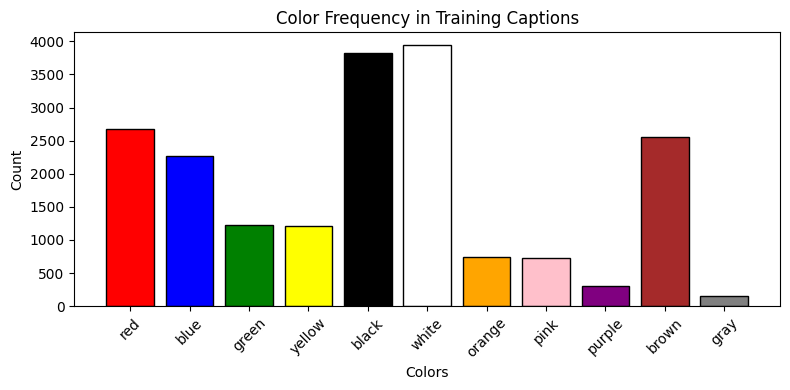

In [11]:
# sanity check
colors = ['red', 'blue', 'green', 'yellow', 'black', 'white','orange', 'pink', 'purple', 'brown', 'gray']
color_distribution = {color: vocab.word_freq[color] for color in colors}

plt.figure(figsize=(8, 4))
plt.bar(color_distribution.keys(), color_distribution.values(), color=colors, edgecolor='black')
plt.title("Color Frequency in Training Captions")
plt.xlabel("Colors")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

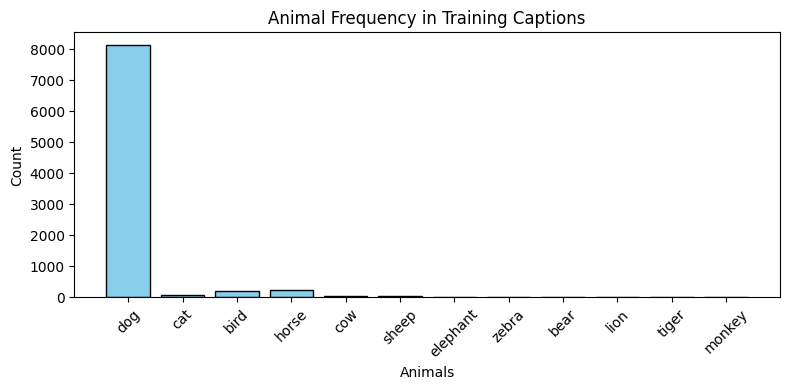

In [12]:
# sanity check
animals = ['dog', 'cat', 'bird', 'horse', 'cow', 'sheep', 'elephant', 'zebra', 'giraffe', 'bear', 'lion', 'tiger', 'monkey']
animal_distribution = {animal: vocab.word_freq[animal] for animal in animals if animal in vocab.word_freq}

plt.figure(figsize=(8,4))
plt.bar(animal_distribution.keys(), animal_distribution.values(), color='skyblue', edgecolor='black')
plt.title("Animal Frequency in Training Captions")
plt.xlabel("Animals")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [13]:
training_dataset = Flickr8k_Dataset(PATH_TO_IMAGES, training_data, captions_dict, vocab, transform=image_transforms())
valid_dataset = Flickr8k_Dataset(PATH_TO_IMAGES, valid_data, captions_dict, vocab, transform=image_transforms())
test_dataset = Flickr8k_Dataset(PATH_TO_IMAGES, test_data, captions_dict, vocab, transform=image_transforms())

In [14]:
train_dataloader = DataLoader(training_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [15]:
for images, captions, lengths in train_dataloader:
    print(f"Images shape: {images.shape}")
    print(f"Captions shape: {captions.shape}")
    print(f"Lengths (List): {len(lengths)}")
    break

Images shape: torch.Size([32, 3, 224, 224])
Captions shape: torch.Size([32, 24])
Lengths (List): 32


In [16]:
print(f"Number of training batches: {len(train_dataloader)}")
print(f"Number of validation batches: {len(valid_dataloader)}")
print(f"Number of test batches: {len(test_dataloader)}")

Number of training batches: 938
Number of validation batches: 157
Number of test batches: 157


## Visualization

In [17]:
example_dataset = Flickr8k_Dataset(PATH_TO_IMAGES, test_data, captions_dict, vocab)

In [18]:
def visualize_random_samples(dataset, vocab):
      img, cap_tensor = random.choice(dataset)
      caption = ' '.join([vocab.idx2word[idx.item()] for idx in cap_tensor])
      if isinstance(img, torch.Tensor):
          img = transforms.ToPILImage()(img)
      plt.imshow(img)
      plt.title(caption)
      plt.axis('off')
      plt.show()

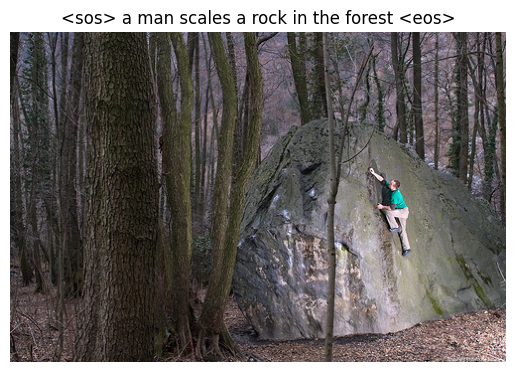

In [24]:
# Note - Image is not transformed.
visualize_random_samples(example_dataset, vocab)

# Model Definition

## Feature Extractor (Resnet101)

In [30]:
class Resnet101(nn.Module):
  def __init__(self):
    super(Resnet101, self).__init__()
    resnet = models.resnet101(weights=models.ResNet101_Weights.DEFAULT)
    modules = list(resnet.children())[:-2]
    self.resnet = nn.Sequential(*modules)

    for params in self.resnet.parameters():
      params.requires_grad = False


  def forward(self,images):
    # images = [batch_size, 3, 224, 224]

    # encoder_out = [batch_size, 2048, 7, 7]
    encoder_out = self.resnet(images)
    return encoder_out

## Decoder (LSTM with attention)

In [29]:
class Attention(nn.Module):
  def __init__(self,feature_dim, hidden_dim, attn_dim):
    super(Attention, self).__init__()
    self.encoder_attn = nn.Linear(feature_dim, attn_dim)
    self.hidden_attn = nn.Linear(hidden_dim, attn_dim)
    self.full_attn = nn.Linear(attn_dim, 1)
    self.relu = nn.ReLU()

  def forward(self, encoder_out, hidden):
    # encoder_out = [batch_size, 49, 2048]
    # hidden = [batch_size, hidden_dim]

    # attn1 = [batch_size, 49, attn_dim]
    attn1 = self.encoder_attn(encoder_out)
    # attn2 = [batch_size, 1, attn_dim]
    attn2 = self.hidden_attn(hidden).unsqueeze(1)
    # attn = [batch_size, 49, attn_dim]
    attn = self.relu(attn1 + attn2)
    # out = [batch_size, 49]
    out = self.full_attn(attn).squeeze(2)
    # alpha = [batch_size, 49]
    alpha = torch.softmax(out, dim=1)
    # context = [batch_size, 2048]
    context = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)
    return context, alpha

In [59]:
class DecoderWithAttention(nn.Module):
    def __init__(self, attention_dim, embed_dim, hidden_dim, vocab, encoder_dim=2048, dropout=0.5):
        super(DecoderWithAttention, self).__init__()
        self.vocab = vocab
        self.vocab_size = len(vocab)
        self.encoder_dim = encoder_dim

        self.attention = Attention(encoder_dim, hidden_dim, attention_dim)
        self.embedding = nn.Embedding(self.vocab_size, embed_dim)
        self.embedding.weight = nn.Parameter(self.vocab.embeddings, requires_grad=False)

        self.decode_step = nn.LSTMCell(embed_dim + encoder_dim, hidden_dim, bias=True)
        self.init_h = nn.Linear(encoder_dim, hidden_dim)
        self.init_c = nn.Linear(encoder_dim, hidden_dim)
        self.f_beta = nn.Linear(hidden_dim, encoder_dim)
        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(hidden_dim, self.vocab_size)
        self.dropout_layer = nn.Dropout(p=dropout)

        self.init_weights()


    def init_weights(self):
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)


    def init_hidden_state(self, encoder_out):
        # encoder_out: [batch_size, 49, 2048]

        # mean_encoder_out = [batch_size, 2048]
        mean_encoder_out = encoder_out.mean(dim=1)
        # h = [batch_size, hidden_dim]
        h = self.init_h(mean_encoder_out)
        # c = [batch_size, hidden_dim]
        c = self.init_c(mean_encoder_out)
        return h, c

    def forward(self, encoder_out, encoded_captions, caption_lengths):
        # encoder_out = [batch_size, 2048, 7, 7]
        # encoder_captions = [batch_size, max_seq_len]
        # caption_lengths(List) = batch_size

        batch_size = encoder_out.size(0)
        # encoder_out = [batch_size, 2048, 49]
        encoder_out = encoder_out.view(batch_size, self.encoder_dim, -1)
        # encoder_out = [batch_size, 49, 2048]
        encoder_out = encoder_out.permute(0, 2, 1)
        # num_pixels = 49
        num_pixels = encoder_out.size(1)

        # caption_lengths = [batch_size]
        # sort_ind = [batch_size]
        caption_lengths, sort_ind = torch.sort(torch.tensor(caption_lengths), dim=0, descending=True)
        # encoder_out = [batch_size, 49, 2048]
        encoder_out = encoder_out[sort_ind]
        # encoded_captions = [batch_size,max_seq_len]
        encoded_captions = encoded_captions[sort_ind]
        # embeddings = [batch_size, max_seq_len, embed_dim]
        embeddings = self.embedding(encoded_captions)
        # h = [batch_size, hidden_dim]
        # c = [batch_size, hidden_dim]
        h, c = self.init_hidden_state(encoder_out)

        decode_lengths = (caption_lengths - 1).tolist()
        max_decode_len = max(decode_lengths)
        # predictions = [batch_size, max_decode_len, vocab_size]
        # alphas = [batch_size, max_decode_len, vocab_size]
        predictions = torch.zeros(batch_size, max_decode_len, self.vocab_size).to(encoder_out.device)
        alphas = torch.zeros(batch_size, max_decode_len, num_pixels).to(encoder_out.device)

        for t in range(max_decode_len):
            batch_size_t = sum([l > t for l in decode_lengths])
            # attention_weighted_encoding = [batch_size_t, 2048]
            # alpha = [batch_size_t, 49]
            attention_weighted_encoding, alpha = self.attention(
                encoder_out[:batch_size_t], h[:batch_size_t]
            )
            # gate = [batch_size_t, 2048]
            gate = self.sigmoid(self.f_beta(h[:batch_size_t]))
            # attention_weighted_encoding = [batch_size_t, 2048]
            attention_weighted_encoding = gate * attention_weighted_encoding
            # lstm_input = [batch_size_t, embed_dim + 2048]
            lstm_input = torch.cat([embeddings[:batch_size_t, t, :], attention_weighted_encoding], dim=1)
            # h = [batch_size_t, hidden_dim]
            # c = [batch_size_t, hidden_dim]
            h, c = self.decode_step(lstm_input, (h[:batch_size_t], c[:batch_size_t]))
            # preds = [batch_size_t, vocab_size]
            preds = self.fc(self.dropout_layer(h))
            predictions[:batch_size_t, t, :] = preds
            alphas[:batch_size_t, t, :] = alpha

        return predictions, encoded_captions, decode_lengths, alphas, sort_ind

## Combined Model

In [60]:
class ImageCaptioningModel(nn.Module):
    def __init__(self, encoder, decoder):
        super(ImageCaptioningModel, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, images, captions, lengths):
        # images = [batch_size, 3, 224, 224]
        # captions = [batch_size, max_seq_len]
        # lengths(List) = batch_size

        # encoder_out = [batch_size, 2048, 7, 7]
        encoder_out = self.encoder(images)
        # predictions = [batch_size, max_decode_len, vocab_size]
        # captions_sorted = [batch_size,max_seq_len]
        # decode_lengths = List(int)
        # alphas = [batch_size, max_decode_len, 49]
        # sort_ind = [batch_size]
        predictions, captions_sorted, decode_lengths, alphas, sort_ind = self.decoder(
            encoder_out, captions, lengths
        )
        return predictions, captions_sorted, decode_lengths, alphas, sort_ind

# Training the  model

## Model Initialization

In [61]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embed_dim = 300
hidden_size = 512
learning_rate = 1e-4
weight_decay = 1e-5
patience = 3
num_epochs = 10
attention_dim = 512

In [62]:
encoder = Resnet101().to(device)
decoder = DecoderWithAttention(attention_dim, embed_dim, hidden_size, vocab).to(device)
model = ImageCaptioningModel(encoder, decoder).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=vocab.word2idx['<pad>'])
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [63]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 11,858,868 trainable parameters


In [64]:
def print_trainable_params(module, name):
    print(f"Trainable parameters in {name}:")
    for param_name, param in module.named_parameters():
        if param.requires_grad:
            print(f"  {param_name}")

print_trainable_params(model.encoder, "Encoder")  # should be empty
print_trainable_params(model.decoder, "Decoder")

Trainable parameters in Encoder:
Trainable parameters in Decoder:
  attention.encoder_attn.weight
  attention.encoder_attn.bias
  attention.hidden_attn.weight
  attention.hidden_attn.bias
  attention.full_attn.weight
  attention.full_attn.bias
  decode_step.weight_ih
  decode_step.weight_hh
  decode_step.bias_ih
  decode_step.bias_hh
  init_h.weight
  init_h.bias
  init_c.weight
  init_c.bias
  f_beta.weight
  f_beta.bias
  fc.weight
  fc.bias


## Training and Evaluation Loops

In [75]:
def train_fn(model, dataloader, optimizer, criterion, device, alpha_c=1.0, grad_clip=5.0):
    model.train()
    total_loss = 0.0

    for images, captions, lengths in dataloader:
        images = images.to(device)
        captions = captions.to(device)
        predictions, captions_sorted, decode_lengths, alphas, _ = model(images, captions, lengths)
        targets = captions_sorted[:, 1:]
        scores = pack_padded_sequence(predictions, decode_lengths, batch_first=True).data
        targets = pack_padded_sequence(targets, decode_lengths, batch_first=True).data
        loss = criterion(scores, targets)
        loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()
        optimizer.zero_grad()
        loss.backward()

        if grad_clip is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(dataloader)


def evaluation_fn(model, dataloader, criterion, device, alpha_c=1.0):
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for images, captions, lengths in dataloader:
            images = images.to(device)
            captions = captions.to(device)
            predictions, captions_sorted, decode_lengths, alphas, _ = model(images, captions, lengths)
            targets = captions_sorted[:, 1:]
            scores, _ = pack_padded_sequence(predictions, decode_lengths, batch_first=True)
            targets, _ = pack_padded_sequence(targets, decode_lengths, batch_first=True)
            loss = criterion(scores, targets)
            loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()
            total_loss += loss.item()

    return total_loss / len(dataloader)

## Sampling

In [76]:
def beam_search(model, image, vocab, beam_size=5, max_len=20):
    model.eval()
    with torch.no_grad():
        image = image.unsqueeze(0).to(device)
        features = model.encoder(image)
        features = features.view(1, -1, features.size(-1))

        h, c = model.decoder.init_hidden_state(features)
        sequences = [[[], 0.0, h, c]]

        for _ in range(max_len):
            all_candidates = []

            for seq, score, h, c in sequences:
                if len(seq) > 0 and seq[-1] == vocab.word2idx['<eos>']:
                    all_candidates.append((seq, score, h, c))
                    continue

                prev_token = torch.tensor(
                    [seq[-1]] if seq else [vocab.word2idx['<sos>']]
                ).to(device)

                embedding = model.decoder.embedding(prev_token)
                context, _ = model.decoder.attention(features, h)
                lstm_input = torch.cat([embedding, context], dim=1)
                h, c = model.decoder.decode_step(lstm_input, (h, c))
                output = model.decoder.fc(model.decoder.dropout_layer(h))
                log_probs = torch.log_softmax(output, dim=1)

                top_log_probs, top_indices = torch.topk(log_probs, beam_size)

                for i in range(beam_size):
                    token = top_indices[0, i].item()
                    new_seq = seq + [token]
                    new_score = score + top_log_probs[0, i].item()
                    all_candidates.append((new_seq, new_score, h, c))

            sequences = sorted(all_candidates, key=lambda tup: tup[1], reverse=True)[:beam_size]

        best_seq = sequences[0][0]
        caption = [vocab.idx2word[idx] for idx in best_seq if idx not in {
            vocab.word2idx['<sos>'], vocab.word2idx['<eos>'], vocab.word2idx['<pad>']
        }]
        return ' '.join(caption)

In [77]:
def generate_caption(model, image_path_or_url, vocab, beam_size=5, max_len=20):
    model.eval()

    try:
        if image_path_or_url.startswith("http://") or image_path_or_url.startswith("https://"):
            headers = {
                "User-Agent": "Mozilla/5.0",
                "Accept": "image/*,*/*",
                "Referer": image_path_or_url.split("/")[2],
            }
            response = requests.get(image_path_or_url, headers=headers, stream=True, timeout=10)

            if response.status_code == 403:
                return "403 Forbidden: Try a different image source."
            response.raise_for_status()

            if "image" not in response.headers.get("Content-Type", ""):
                return "URL does not point to an image."

            image = Image.open(BytesIO(response.content)).convert("RGB")

        elif os.path.exists(image_path_or_url):
            image = Image.open(image_path_or_url).convert("RGB")
        else:
            return "Invalid image path or URL."

        transform = image_transforms()
        image_tensor = transform(image).unsqueeze(0).to(device)

        caption = beam_search(
            model=model,
            image=image_tensor[0],
            vocab=vocab,
            beam_size=beam_size,
            max_len=max_len
        )

        return caption

    except requests.exceptions.RequestException as e:
        return f"Network error: {str(e)}"
    except Exception as e:
        return f"Unexpected error: {str(e)}"

## Training the model

In [78]:
print(f"Training on: {device}")

Training on: cpu


In [80]:
best_val_loss = float('inf')
count_patience = 0

for epoch in range(num_epochs):
    train_loss = train_fn(model, train_dataloader, optimizer, criterion, device)
    val_loss = evaluation_fn(model, valid_dataloader, criterion, device)

    print(f"Epoch {epoch+1}/{10}")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
      best_val_loss = val_loss
      count_patience = 0
      torch.save(model.state_dict(), "new_best_model.pth")
      print("Saved new best model")
    else:
      count_patience += 1
      if count_patience >= patience:
          print("Early stopping triggered.")
          break

    # Test generation
    test_image = random.choice(test_data)
    test_path = os.path.join(PATH_TO_IMAGES, test_image)
    caption = generate_caption(model, test_path, vocab)
    print(f"Sample Generation: {caption}\n")

# Inference

In [ ]:
model.load_state_dict(torch.load("new_best_model.pth"))

<All keys matched successfully>

In [ ]:
test_loss = evaluation_fn(model, test_dataloader, criterion, device)
print(f"Test Loss: {test_loss:.3f}")

In [ ]:
def display_captioned_images(model, test_data, vocab, path_to_images, num_images=9, cols=3):
    rows = (num_images + cols - 1) // cols
    plt.figure(figsize=(3 * cols, 3 * rows))

    for i in range(num_images):
        test_image = random.choice(test_data)
        test_image_path = os.path.join(path_to_images, test_image)

        caption = generate_caption(model, test_image_path, vocab)
        image = Image.open(test_image_path)

        max_words_per_line = 5
        caption_words = caption.split()
        wrapped_caption = '\n'.join([' '.join(caption_words[j:j + max_words_per_line])
                                     for j in range(0, len(caption_words), max_words_per_line)])

        plt.subplot(rows, cols, i + 1)
        plt.imshow(image)
        plt.title(wrapped_caption, fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

display_captioned_images(model, test_data, vocab, PATH_TO_IMAGES)

In [ ]:
url = "https://media.istockphoto.com/id/1037329974/photo/woman-riding-horse-dramatic-sky.jpg?s=612x612&w=0&k=20&c=9I7jS687CBoUFbkTh6q12jpTHi25Q8liHBQK9mBoUVI="
generate_caption(model, url, vocab)

''